<img src='img/logo.png' alt='Drawing' style='width:2000px;'/>
<img src='img/_logo.JPG' alt='Drawing' style='width:2000px;'/>

# <font color=blue>4. OpenSeesPy</font>
| | |
|-|-|
| | |
| 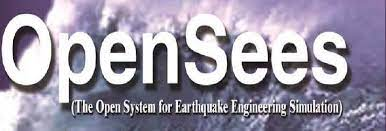 |
| | | |

### What is different from tcl version?

Essentially, nothing is different aside from the syntax.

OpenSees Tcl syntax: ```command Argument 1 Argument 2 ... Argument n``` 

For example: ``` node 3 168.0 0.0``` 

OpenSees Python syntax: ```command(Argument 1, Argument 2, ..., Argument n)```

For example: ``` node(3, 168.0,  0.0)```

*In python envrionment it is not smart to import a library without an identifier. You may mess up things easily.*

You can use ``` node(3, 168.0,  0.0)``` if you do ```from openseespy.opensees import *```

**But I would rather do this: ```import openseespy.opensees as ops```** and use ```ops.node(3, 168.0,  0.0)``` 

## <font color=blue>4.1 Analysis of a Single Degree of Freedom System</font>

In [4]:
#  ---------------------------------------
#  Import Libraries
#  ---------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops

# Wipe any existing model
ops.wipe()
ops.model('basic', '-ndm', 1, '-ndf', 1)  # 1 dimension, 1 dof per node

# Establish nodes
node1 = 1 # Tag for bottom node
node2 = 2 # Tag for top node

# Let's assume that they are at the same location
coord1 = 0.0 # 1 dimensional coordinate for node 1
coord2 = 0.0 # 1 dimensional coordinate for node 2

# Create the nodes
ops.node(node1, coord1)
ops.node(node2, coord2)

# Fix node 1, release node 2 (this is optional, by default it is unrestrained)
ops.fix(node1, 1)
ops.fix(node2, 0)

# Assign the mass to the free end
mass = 1
ops.mass(node2, mass)

# Define materal
mat_tag = 1
mat_type = 'Elastic'
T_n = 1.0 # natural period 
k_el = 4 * np.pi ** 2 * mass / T_n ** 2 # stiffness
ops.uniaxialMaterial(mat_type, mat_tag, k_el)

# Assign zero length element
ele_tag = 1 # tag for element
ops.element('zeroLength', ele_tag, node1, node2, "-mat", mat_tag, "-dir", 1, '-doRayleigh', 1)

# Set inital stiffness proportional damping
xi = 0.05 # damping ratio
angular_freq = ops.eigen('-fullGenLapack', 1)[0] ** 0.5
alpha_m = 0.0
beta_k = 0.0
beta_k_comm = 0.0
beta_k_init = 2 * xi / angular_freq
ops.rayleigh(alpha_m, beta_k, beta_k_init, beta_k_comm)

# Define the load pattern
record_filename = 'tools//test_motion.txt' # acceleration time history
dt = 0.01 # time step of record
A_g = np.loadtxt(record_filename) # load the file
load_tag_dynamic = 1 # tag for time series to use
pattern_tag_dynamic = 1 # tag for load pattern to use
values = list(-1 * A_g)  # should be negative
ops.timeSeries('Path', load_tag_dynamic, '-dt', dt, '-values', *values) # time series object
ops.pattern('UniformExcitation', pattern_tag_dynamic, 1, '-accel', load_tag_dynamic) # pattern object

# Run the dynamic analysis
# Wipe any previous analysis object
ops.wipeAnalysis()

# Convergence Test -- determines when convergence has been achieved.
tol = 1.0e-8
iterations = 50
ops.test('NormDispIncr', tol, iterations, 0, 2)

# SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
ops.algorithm('Newton', '-initial')

# DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
ops.numberer('RCM')

# SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
ops.system('SparseGeneral')

# Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
ops.constraints('Transformation')

# Integrator -- determines the predictive step for time t+dt
ops.integrator('Newmark', 0.5, 0.25)

# AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
ops.analysis('Transient')

analysis_time = (len(values) - 1) * dt
analysis_dt = 0.001
outputs = {
    "time": [],
    "rel_disp": [],
    "rel_accel": [],
    "rel_vel": [],
    "force": []
}

# Perform step by step analysis
while ops.getTime() < analysis_time:
    curr_time = ops.getTime()
    ops.analyze(1, analysis_dt)

    # Save outputs, you can use but you do not need recorders!
    outputs["time"].append(curr_time)
    outputs["rel_disp"].append(ops.nodeDisp(node2, 1))
    outputs["rel_vel"].append(ops.nodeVel(node2, 1))
    outputs["rel_accel"].append(ops.nodeAccel(node2, 1))
    ops.reactions()
    outputs["force"].append(-ops.nodeReaction(node1, 1))  # Negative since diff node

# Wipe the model
ops.wipe()
# We saved everything as list, we can convert them to an array
for item in outputs:
    outputs[item] = np.array(outputs[item])

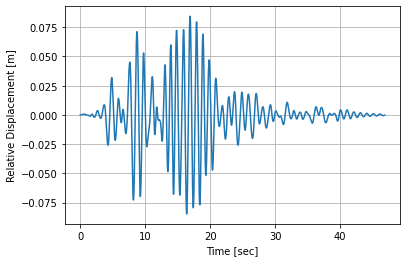

In [5]:
plt.figure()
plt.plot(outputs["time"], outputs["rel_disp"])
plt.xlabel('Time [sec]')
plt.ylabel('Relative Displacement [m]')
plt.grid(True)
plt.show()

### A modelling approach with more general use
We can do better than this, we can use functions, import things, we can convert these into packages modules... You see, we only need few variables if we are going to do SDoF analysis. Material, Signal, Damping and Mass. We can convert what we have to a function.

In [6]:
#  ---------------------------
#  Definition of units
#  ---------------------------
# Basic Units
m = 1.0
kN = 1.0
sec = 1.0

# Length
mm = m / 1000.0
cm = m / 100.0
inch = 25.4 * mm
ft = 12.0 * inch

# Force
N = kN / 1000.0
kip = kN * 4.448221615

# Mass (tonnes)
tonne = kN * sec ** 2 / m
kg = N * sec ** 2 / m

# Gravity
g = 9.81*m / sec**2

# Stress (kN/m2 or kPa)
Pa = N / (m ** 2)
kPa = Pa * 1.0e3
MPa = Pa * 1.0e6
GPa = Pa * 1.0e9
ksi = 6.8947573 * MPa
psi = 1e-3 * ksi

# Time
min = 60*sec
hr = 60*min

In [7]:
#  ------------------------------------------------------------
#  Libraries, Packages, Functions whatever you want to import!
#  ------------------------------------------------------------
import matplotlib.pyplot as plt
import numpy as np
import openseespy.opensees as ops
# In fact you can save this function elsewhere and then import.
# Let's say, this function is inside myfunction.py. You can then write from myfunction import get_inelastic_response
def get_inelastic_response(mass, motion, dt, xi, Material):
    """
    Run seismic analysis of a nonlinear SDOF

    :param mass: SDOF mass
    :param k_spring: spring stiffness
    :param f_yield: yield strength
    :param motion: list, acceleration values
    :param dt: float, time step of acceleration values
    :param xi: damping ratio
    :param r_post: post-yield stiffness
    :return:
    """
    
    # Wipe any existing model
    ops.wipe()
    ops.model('basic', '-ndm', 1, '-ndf', 1)  # 1 dimension, 1 dof per node

    # Establish nodes
    node1 = 1 # Tag for bottom node
    node2 = 2 # Tag for top node

    # Nodes are located at the same location
    coord1 = 0.0 # 1 dimensional coordinate for node 1
    coord2 = 0.0 # 1 dimensional coordinate for node 2

    # Create the nodes
    ops.node(node1, coord1)
    ops.node(node2, coord2)

    # Fix node 1, release node 2 (this is optional, by default it is unrestrained)
    ops.fix(node1, 1)
    ops.fix(node2, 0)

    # Assign the mass to the free end
    ops.mass(node2, mass)

    # Define materal
    mat_tag = 1
    mat_type = Material[0]
    mat_props = Material[1:]
    ops.uniaxialMaterial(mat_type, mat_tag, *mat_props)

    # Assign zero length element
    ele_tag = 1 # tag for element
    ops.element('zeroLength', ele_tag, node1, node2, "-mat", mat_tag, "-dir", 1, '-doRayleigh', 1)

    # Set inital stiffness proportional damping
    angular_freq = ops.eigen('-fullGenLapack', 1)[0] ** 0.5
    alpha_m = 0.0
    beta_k = 0.0
    beta_k_comm = 0.0
    beta_k_init = 2 * xi / angular_freq
    ops.rayleigh(alpha_m, beta_k, beta_k_init, beta_k_comm)
    
    # Define the load pattern
    load_tag_dynamic = 1 # tag for time series to use
    pattern_tag_dynamic = 1 # tag for load pattern to use
    values = list(-1 * motion)  # should be negative
    ops.timeSeries('Path', load_tag_dynamic, '-dt', dt, '-values', *values) # time series object
    ops.pattern('UniformExcitation', pattern_tag_dynamic, 1, '-accel', load_tag_dynamic) # pattern object

    # Run the dynamic analysis
    # Wipe any previous analysis object
    ops.wipeAnalysis()

    # Convergence Test -- determines when convergence has been achieved.
    tol = 1.0e-8
    iterations = 50
    ops.test('NormDispIncr', tol, iterations, 0, 2)
    
    # SolutionAlgorithm -- determines the sequence of steps taken to solve the non-linear equation at the current time step
    ops.algorithm('Newton', '-initial')
    
    # DOF_Numberer -- determines the mapping between equation numbers and degrees-of-freedom
    ops.numberer('RCM')
    
    # SystemOfEqn/Solver -- within the solution algorithm, it specifies how to store and solve the system of equations in the analysis
    ops.system('SparseGeneral')
    
    # Constraints handler: determines how the constraint equations are enforced in the analysis -- how it handles the boundary conditions/imposed displacements
    ops.constraints('Transformation')
    
    # Integrator -- determines the predictive step for time t+dt
    ops.integrator('Newmark', 0.5, 0.25)
    
    # AnalysisType -- defines what type of analysis is to be performed ('Static', 'Transient' etc.)
    ops.analysis('Transient')
    
    analysis_time = (len(values) - 1) * dt
    analysis_dt = 0.001
    outputs = {
        "time": [],
        "rel_disp": [],
        "rel_accel": [],
        "rel_vel": [],
        "force": []
    }

    # Perform step by step analysis
    while ops.getTime() < analysis_time:
        curr_time = ops.getTime()
        ops.analyze(1, analysis_dt)
        outputs["time"].append(curr_time)
        outputs["rel_disp"].append(ops.nodeDisp(node2, 1))
        outputs["rel_vel"].append(ops.nodeVel(node2, 1))
        outputs["rel_accel"].append(ops.nodeAccel(node2, 1))
        ops.reactions()
        outputs["force"].append(-ops.nodeReaction(node1, 1))  # Negative since diff node
    ops.wipe()
    for item in outputs:
        outputs[item] = np.array(outputs[item])

    return outputs

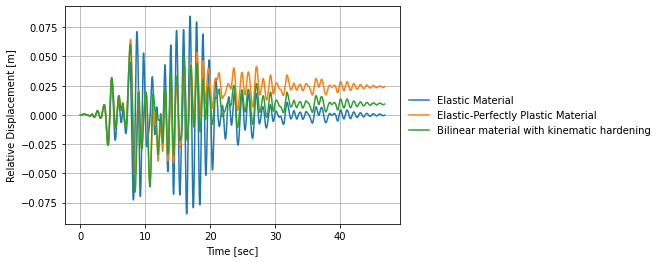

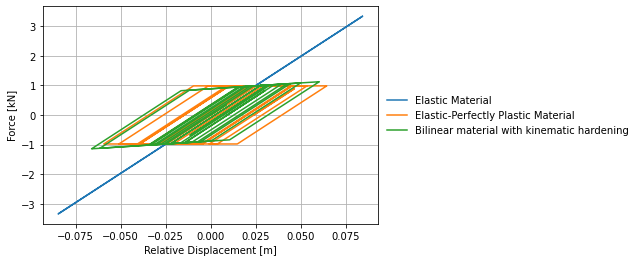

In [8]:
#  ------------------------------------------------------------------------------------------------------------
#  Definition input parameters for our model
#  ------------------------------------------------------------------------------------------------------------
record_filename = 'tools//test_motion.txt' # acceleration time history
dt = 0.01*sec # time step of record
A_g = np.loadtxt(record_filename) # load the file
T_n = 1.0*sec # natural period 
xi = 0.05 # damping ratio
mass = 1*tonne # mass
eta = 0.1 # strength factor, reduce this to make it nonlinear
F_y = eta*mass*g # Yield strength
k_i = 4 * np.pi ** 2 * mass / T_n ** 2 # initial stiffness
u_y = F_y/k_i # yield displacement
r_post = 0.1 # strain-hardening ratio (ratio between post-yield tangent and initial elastic tangent)

# Material properties
Material1 = ['Elastic', k_i]
Material2 = ['ElasticPP', k_i, u_y]
Material3 = ['Steel01', F_y, k_i, r_post]

# Run the model
outputs1 = get_inelastic_response(mass, A_g, dt, xi, Material1)
outputs2 = get_inelastic_response(mass, A_g, dt, xi, Material2)
outputs3 = get_inelastic_response(mass, A_g, dt, xi, Material3)

plt.figure()
plt.plot(outputs1["time"], outputs1["rel_disp"], label='Elastic Material')
plt.plot(outputs2["time"], outputs2["rel_disp"], label='Elastic-Perfectly Plastic Material')
plt.plot(outputs3["time"], outputs3["rel_disp"], label='Bilinear material with kinematic hardening')
plt.xlabel('Time [sec]')
plt.ylabel('Relative Displacement [m]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(True)
plt.show()

plt.figure()
plt.plot(outputs1["rel_disp"], outputs1["force"], label='Elastic Material')
plt.plot(outputs2["rel_disp"], outputs2["force"], label='Elastic-Perfectly Plastic Material')
plt.plot(outputs3["rel_disp"], outputs3["force"], label='Bilinear material with kinematic hardening')
plt.xlabel('Relative Displacement [m]')
plt.ylabel('Force [kN]')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), frameon=False)
plt.grid(True)
plt.show()